In [3]:
import pandas as pd
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = "Arial"

from matplotlib.pyplot import figure



In [341]:
from scipy.stats import mannwhitneyu

In [15]:
def cpd2rns(cpd):
    url = 'http://rest.kegg.jp/link/rn/' + cpd
    r = requests.get(url)
    df = pd.DataFrame([x.split('\t') for x in r.text.split('\n')],columns=['cpd','rn'])
    df = df.iloc[0:-1]
    return df

def get_coenzyme_coupled_deltaGs(coenzyme_pair,network,deltaG):
    
    charged = cpd2rns(coenzyme_pair['charged'])
    uncharged = cpd2rns(coenzyme_pair['uncharged'])
    rns = list(set(charged.rn).intersection(set(uncharged.rn)))
    rns = [x.split(':')[1] for x in rns]
    coenzyme_rns = network[network.rn.isin(rns)]
    coenzyme_rns_sign = coenzyme_rns[coenzyme_rns.cid.isin([coenzyme_pair['charged']])]
    coenzyme_rns_sign['multiplier'] = np.sign(coenzyme_rns_sign.s)
    dg_sb = deltaG[deltaG['!MiriamID::urn:miriam:kegg.reaction'].isin(coenzyme_rns_sign.rn)].set_index('!MiriamID::urn:miriam:kegg.reaction')
    dg_sb = dg_sb.join(coenzyme_rns_sign.set_index('rn'))
    dg_sb['dG0_(kJ/mol)'] = dg_sb['!dG0_prime (kJ/mol)']*dg_sb['multiplier']
    return dg_sb

In [14]:
def ko2rn():
    url = 'http://rest.kegg.jp/link/rn/ko'
    r = requests.get(url)
    df = pd.DataFrame([x.split('\t') for x in r.text.split('\n')],columns=['ko','rn'])
    df = df.iloc[0:-1]
    return df


In [12]:
network = pd.read_csv('../../networkExpansionPy/networkExpansionPy/assets/KEGG/network_full.csv')
dg= pd.read_csv('../../networkExpansionPy/networkExpansionPy/assets/reaction_free_energy/kegg_reactions_CC_ph7.0.csv')


In [5]:
dg

,!MiriamID::urn:miriam:kegg.reaction,!dG0_prime (kJ/mol),!sigma[dG0] (kJ/mol),!pH,!I (mM),!T (Kelvin),!Note
0,R00002,-766.9,47.4,7.0,0.1,298.15,NaN
1,R00004,-15.8,0.4,7.0,0.1,298.15,NaN
2,R00005,-78.8,15.2,7.0,0.1,298.15,NaN
3,R00006,32.2,7.4,7.0,0.1,298.15,NaN
4,R00008,16.3,4.7,7.0,0.1,298.15,NaN
...,...,...,...,...,...,...,...
8310,R09714,NaN,NaN,7.0,0.1,298.15,uncertainty is too high
8311,R09715,-169.8,49.3,7.0,0.1,298.15,NaN
8312,R09716,NaN,NaN,7.0,0.1,298.15,uncertainty is too high
8313,R09717,1.5,5.4,7.0,0.1,298.15,NaN


In [18]:
coenzyme_pairs = pd.read_csv('../assets/coenzyme_pairs.csv')
dfs = []
for idx,row in coenzyme_pairs.iterrows():
    coenzyme_pair = {}
    coenzyme_pair['charged'] = row.Charged
    coenzyme_pair['uncharged'] = row.Uncharged
    df = get_coenzyme_coupled_deltaGs(coenzyme_pair,network,dg)
    df['coenzyme_pair'] = row['Coenzyme Pair']
    dfs.append(df)
    
df_all = pd.concat(dfs,axis=0).reset_index()

<ipython-input-15-db45edcc0f95>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coenzyme_rns_sign['multiplier'] = np.sign(coenzyme_rns_sign.s)


In [323]:
#df_all

In [19]:
coenzyme_pair['charged'] = 'C00004'    
coenzyme_pair['uncharged'] = 'C00003'    
charged = cpd2rns(coenzyme_pair['charged'])
uncharged = cpd2rns(coenzyme_pair['uncharged'])
rns = list(set(charged.rn).intersection(set(uncharged.rn)))
rns = [x.split(':')[1] for x in rns]
coenzyme_rns = network[network.rn.isin(rns)]

In [20]:
df_nad = df_all[df_all['coenzyme_pair'].isin(['NAD/NADH'])]

In [21]:
df_nad = df_all[df_all['coenzyme_pair'].isin(['NAD/NADH'])]
nad_network = network[network.rn.isin(df_nad['!MiriamID::urn:miriam:kegg.reaction'].tolist())]
nad_o2 = nad_network[nad_network.cid.isin(['C00007'])].rn.tolist()
df_nad['oxygen']= df_nad['!MiriamID::urn:miriam:kegg.reaction'].isin(nad_o2)

df_nadp = df_all[df_all['coenzyme_pair'].isin(['NADP/NADPH'])]
nadp_network = network[network.rn.isin(df_nadp['!MiriamID::urn:miriam:kegg.reaction'].tolist())]
nadp_o2 = nadp_network[nadp_network.cid.isin(['C00007'])].rn.tolist()
df_nadp['oxygen']= df_nadp['!MiriamID::urn:miriam:kegg.reaction'].isin(nadp_o2)


<ipython-input-21-f758db38a17b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nad['oxygen']= df_nad['!MiriamID::urn:miriam:kegg.reaction'].isin(nad_o2)
<ipython-input-21-f758db38a17b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nadp['oxygen']= df_nadp['!MiriamID::urn:miriam:kegg.reaction'].isin(nadp_o2)


In [22]:
df_nicotinamide = pd.concat([df_nad,df_nadp],axis=0)

In [23]:
df_nicotinamide['K'] = np.abs(df_nicotinamide['dG0_(kJ/mol)'])

In [24]:
rxns_oxygen = df_nicotinamide[df_nicotinamide['oxygen']]['!MiriamID::urn:miriam:kegg.reaction'].unique().tolist()
rxns_no_oxygen = df_nicotinamide[~df_nicotinamide['oxygen']]['!MiriamID::urn:miriam:kegg.reaction'].unique().tolist()

In [25]:
df_no_o2 =df_nicotinamide[~df_nicotinamide['oxygen']]

In [30]:
df_no_o2_fe = df_no_o2[~df_no_o2['dG0_(kJ/mol)'].isna()]

In [269]:
reactions_far = df_no_o2[df_no_o2['K'] > 60]['!MiriamID::urn:miriam:kegg.reaction'].tolist()
reactions_close = df_no_o2[df_no_o2['K'] < 10]['!MiriamID::urn:miriam:kegg.reaction'].tolist()

In [31]:
upper_cutoff = np.percentile(df_no_o2_fe.K,90)
lower_cutoff = np.percentile(df_no_o2_fe.K,10)

reactions_far = df_no_o2[df_no_o2['K'] > upper_cutoff]['!MiriamID::urn:miriam:kegg.reaction'].tolist()
reactions_close = df_no_o2[df_no_o2['K'] < lower_cutoff]['!MiriamID::urn:miriam:kegg.reaction'].tolist()


In [16]:
ko_rn = ko2rn()
ko_rn['ko']= ko_rn['ko'].apply(lambda x: x.split(':')[1])
ko_rn['rn']= ko_rn['rn'].apply(lambda x: x.split(':')[1])

In [32]:
ko_far = ko_rn[ko_rn.rn.isin(reactions_far)].ko.unique().tolist()
ko_close = ko_rn[ko_rn.rn.isin(reactions_close)].ko.unique().tolist()

In [26]:
ko_oxygen = ko_rn[ko_rn.rn.isin(rxns_oxygen)].ko.unique().tolist()
ko_noxy = ko_rn[ko_rn.rn.isin(rxns_no_oxygen)].ko.unique().tolist()

ko_oxygen2 = list(set(ko_oxygen)- set(ko_noxy))
ko_noxy2 = list(set(ko_noxy)- set(ko_oxygen))
ko_oxygen = ko_oxygen2
ko_noxy = ko_noxy2



In [33]:
ko_close2 = list(set(ko_close)- set(ko_far))
ko_far2 = list(set(ko_far)- set(ko_close))
ko_close = ko_close2
ko_far = ko_far2

In [7]:
#cofactory = pd.read_csv('../scc/cofactory_oxygen/cofactory.OxygenDependence.Jan2020.csv',index_col=0)
cofactory = pd.read_csv('/Users/joshuagoldford/Documents/work/research_projects/coenzyme_redundancy/datasets/scc/cofactory_oxygen/cofactory.OxygenDependence.Jan2020.csv',index_col=0)

In [265]:
cofactory[cofactory['FAD']< 0.5]

,id,domain,FAD,NAD,NADP,Cofactor(s),From,To,Sequence,ko
0,ppj:RK21_02869,1,0.434,0.614,0.077,NAD,148.0,193.0,HEGPVVIIGAGGLGLMAIEVLKAMGAKGAVVVDIDASKREAALAAG,K19961
1,ajs:Ajs_2098,1,0.345,0.459,0.057,-,175.0,221.0,HREPVVMIGAGGLGLMAIEVLKALGGKGAIVVDIDPAKREAALAAGA,K19961
2,ag:BAC80217,1,0.424,0.601,0.060,NAD,175.0,230.0,QSEPVVIIGAGGLGLMALELLKAMQAKGAIVVDIDDSKLEAARAAG...,K19961
3,plu:plu0145,1,0.049,0.098,0.040,-,89.0,129.0,CVAIGGGSTVGLAKAIALQTALPILTIPTTYAGSEMTPVWG,K00217
4,plu:plu0145,2,0.001,0.125,0.022,-,290.0,327.0,AAAGLYDLAKAIGAPVALKDIGMQEKDLDKAAKIATTD,K00217
...,...,...,...,...,...,...,...,...,...,...
595,cau:Caur_2087,2,0.151,0.043,0.030,-,216.0,244.0,AVGIGAGPRHSTAAKQLLTNLKRRLGDAL,K10960
597,chl:Chy400_2250,2,0.151,0.043,0.030,-,216.0,244.0,AVGIGAGPRHSTAAKQLLTNLKRRLGDAL,K10960
599,cag:Cagg_2633,2,0.054,0.035,0.079,-,294.0,327.0,SGQMAAQTLAEYLDAPSEANLRTYERRWWKQYGT,K10960
602,fva:FV113G1_19790,2,0.103,0.128,0.027,-,291.0,320.0,ISGYYLADSINKKGIKNGIIDYQKRTGSMR,K10960


In [323]:
#cofactory_nad = cofactory[~cofactory['Cofactor(s)'].isin(['FAD','-'])]
#cofactory_nad = cofactory[cofactory['FAD']<0.5]
cofactory_nad = cofactory[~cofactory['Cofactor(s)'].isin(['FAD','-'])]
cofactory_nad['specificity'] = np.abs(np.log10(cofactory_nad['NAD'] / cofactory_nad['NADP']))
#cofactory_nad = cofactory_nad.dropna()
cofactory_nad['oxygen'] = cofactory_nad.ko.isin(ko_oxygen)

In [356]:
#len(g2[g2['FAD']>0.5]) / len(g2)

0.04308191018342821

In [357]:
#len(g1[g1['FAD']>0.5]) / len(g1)

In [ ]:
len(g1[g1['FAD']>0.5]) / len(g1)

In [322]:
#z = cofactory[cofactory.ko.isin(['K18277'])]

(0.0, 1.25)

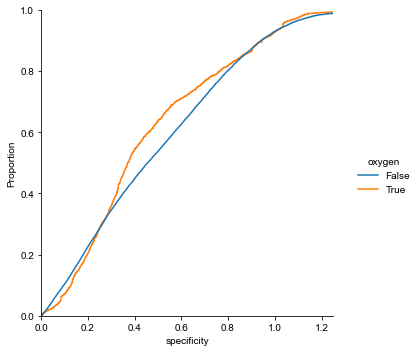

In [336]:
sns.displot(x='specificity',data=cofactory_nad,kind='ecdf',hue='oxygen')
plt.xlim([0,1.25])

In [342]:
mannwhitneyu(cofactory_nad[cofactory_nad['oxygen']].specificity.values,cofactory_nad[~cofactory_nad['oxygen']].specificity.values)

MannwhitneyuResult(statistic=209736941.0, pvalue=3.434307581663712e-08)

In [344]:
np.mean(cofactory_nad[cofactory_nad['oxygen']].specificity.values)

0.46277949875944957

In [345]:
np.mean(cofactory_nad[~cofactory_nad['oxygen']].specificity.values)

0.49490972785512577

In [290]:
g1 = cofactory_nad[cofactory_nad.ko.isin(ko_oxygen)]
g2 = cofactory_nad[cofactory_nad.ko.isin(ko_noxy)]

In [291]:
#sns.scatterplot(x='NAD',y='NADP',data=g2)

In [292]:
c = 0.5

In [293]:
T1 = sum((g1['NAD'] > c) & (g1['NADP'] > c))
nT1 = len(g1) - T1

In [294]:
T2 = sum((g2['NAD'] > c) & (g2['NADP'] > c))
nT2 = len(g2) - T2

In [295]:
T1/(T1+nT1)

0.08836145267372034

In [296]:
T2/(T2+nT2)

0.18823529411764706

In [259]:
sum(g1['Cofactor(s)'].apply(lambda x: len(x.split('/'))) > 1) / len(g1)

0.6116671432656563

In [261]:
sum(g2['Cofactor(s)'].apply(lambda x: len(x.split('/'))) > 1) / len(g2)

0.228882036685642

In [238]:
fisher_exact([[T1,nT1],[T2,nT2]])

(1.1998461109740608, 1.2553329937242974e-07)

In [76]:
from scipy.stats import fisher_exact

In [9]:
cofactory_nad = cofactory[cofactory['Cofactor(s)'].apply(lambda x: 'NAD' in x)]

In [11]:
#cofactory_nad

In [296]:
c = cofactory_nad[cofactory_nad.ko.isin(ko_far + ko_close)]
c_oxy = cofactory_nad[cofactory_nad.ko.isin(ko_noxy + ko_oxygen)]

In [297]:
c['farFromEquil'] = c.ko.isin(ko_far)
c_oxy['oxygen'] = c_oxy.ko.isin(ko_oxygen)

c_oxy['Specificity'] = np.abs(np.log2(c_oxy['NAD']/c_oxy['NADP']))
c['Specificity'] = np.abs(np.log2(c['NAD']/c['NADP']))

<ipython-input-297-2e84b2304c91>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['farFromEquil'] = c.ko.isin(ko_far)
<ipython-input-297-2e84b2304c91>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_oxy['oxygen'] = c_oxy.ko.isin(ko_oxygen)
<ipython-input-297-2e84b2304c91>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [200]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 3,3

In [338]:
c.groupby('farFromEquil').median()

,domain,FAD,NAD,NADP,From,To,Specificity,multi-coenzyme
farFromEquil,,,,,,,,
False,1,0.040,0.619,0.328,71.0,111.0,1.699887,False
True,1,0.052,0.574,0.548,120.0,162.0,1.048184,False


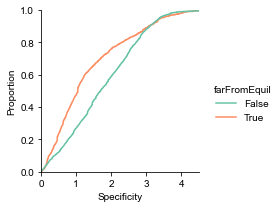

In [314]:
sns.displot(x='Specificity',data=c,hue='farFromEquil',kind='ecdf',palette='Set2',height=3, aspect=1)
plt.xlim([0,4.5])
plt.savefig('eCDF.farFromEq_o2_independent.Specificities.10p.29Nov2021.svg')

In [341]:
c_oxy.groupby('oxygen').median()

,domain,FAD,NAD,NADP,From,To,Specificity
oxygen,,,,,,,
False,1,0.039,0.691,0.302,73.0,111.0,1.513191
True,2,0.533,0.438,0.579,174.0,215.0,1.231249


(0.0, 4.5)

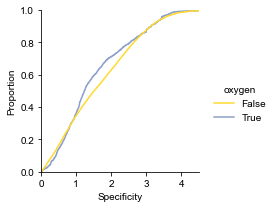

In [299]:
sns.displot(x='Specificity',data=c_oxy,hue='oxygen',kind='ecdf',palette='Set2_r',height=3, aspect=1)
plt.xlim([0,4.5])
#plt.savefig('eCDF.oxygenVsNoOxygen.Specificities.29Nov2021.svg')

In [320]:
c[c['farFromEquil']].Specificity.median()

1.0481835335099652

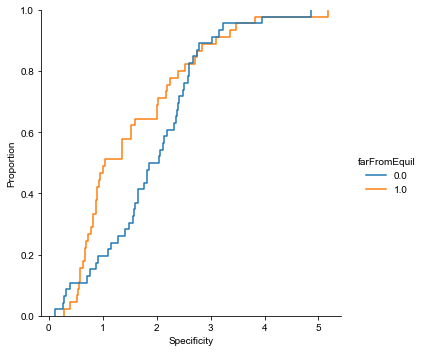

In [329]:
sns.displot(hue='farFromEquil',x='Specificity',data=c.groupby('ko').mean(),kind='ecdf')

In [332]:
cmean = c.groupby('ko').mean()
x = cmean[cmean['farFromEquil'] <0.5].Specificity.values
y = cmean[cmean['farFromEquil'] > 0.5].Specificity.values

In [336]:
mannwhitneyu(x,y)

MannwhitneyuResult(statistic=784.0, pvalue=0.023379810285827484)

In [301]:
c['multi-coenzyme'] = c['Cofactor(s)'].apply(lambda x: 'NAD/NADP' in x)


<ipython-input-301-74367c099a85>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['multi-coenzyme'] = c['Cofactor(s)'].apply(lambda x: 'NAD/NADP' in x)


In [302]:
X = c[['farFromEquil','multi-coenzyme']]
far_from_eq_multi = (X['farFromEquil'] & X['multi-coenzyme']).sum()
close_to_eq_multi = (~X['farFromEquil'] & X['multi-coenzyme']).sum()
far_from_eq_single = (X['farFromEquil'] & ~X['multi-coenzyme']).sum()
close_to_eq_single = (~X['farFromEquil'] & ~X['multi-coenzyme']).sum()


In [313]:
c[~c['farFromEquil']]

,id,domain,FAD,NAD,NADP,Cofactor(s),From,To,Sequence,ko,farFromEquil,Specificity,multi-coenzyme
0,lpil:LIP_2864,1,0.091,0.943,0.682,NAD/NADP,184.0,226.0,PGETVAVIGTGGVGSNVIQIARAFGATEVIAVDIRDDKLRAAR,K14465,False,0.467486,True
2,roa:Pd630_LPD07337,1,0.221,0.540,0.101,NAD,181.0,225.0,FGDRVLVQGAGPVGLAATLVASLSGAGEVVVIGAPASRLDMAKRL,K14465,False,2.418604,False
4,gor:KTR9_4592,1,0.101,0.934,0.135,NAD,183.0,227.0,LADRIAVVAAGGVGSSIVQFAAAAGVAQIIAIDVNDDKLRAVAEL,K14465,False,2.790463,False
5,gta:BCM27_24145,1,0.085,0.934,0.135,NAD,183.0,226.0,LADRIAVVAAGGVGSSIVQFAAAAGVAQIIAIDVNDDKLKAVAA,K14465,False,2.790463,False
6,dit:C3V38_00360,1,0.000,0.922,0.210,NAD,278.0,307.0,GRVVVVGIPPAGTSLDADLARIVRRKIQIK,K14465,False,2.134377,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,sacd:HS1genome_0652,1,0.435,0.174,0.510,NADP,125.0,167.0,QCRTAFVIGSGPIGLLFAMTLVTEGFNVAVLNRRDPNEVESKV,K18125,False,1.551410,False
73,sacd:HS1genome_1599,1,0.310,0.477,0.840,NADP,181.0,222.0,ECRKALITGTGPIGVLVSMLLRTMGMKVYAANRREPKEVEKA,K18125,False,0.816400,False
75,step:IC006_0170,1,0.362,0.395,0.746,NADP,182.0,223.0,CRKATIIGSGPIGQFFAMVFKDNGFKVTVVNRRDPNQIEDKI,K18125,False,0.917323,False
76,cma:Cmaq_1714,1,0.269,0.104,0.715,NADP,183.0,222.0,RRSIVFGTGSTGILISLLLRTVGFEVYVANRRDPLESEAK,K18125,False,2.781360,False


In [303]:
from scipy.stats import mannwhitneyu,ks_2samp

In [306]:
far_from_eq_multi / (far_from_eq_multi + far_from_eq_single)

0.23448275862068965

In [307]:
close_to_eq_multi / (close_to_eq_multi + close_to_eq_single)

0.1578772066170756

In [321]:
mannwhitneyu(c[c['farFromEquil']].Specificity.values,c[~c['farFromEquil']].Specificity.values)

MannwhitneyuResult(statistic=12265808.0, pvalue=1.4362712939724835e-106)

In [305]:
mannwhitneyu(c_oxy[c_oxy['oxygen']].Specificity.values,c_oxy[~c_oxy['oxygen']].Specificity.values)

MannwhitneyuResult(statistic=209399006.5, pvalue=3.961851008085891e-08)

In [106]:
2**c[~c['farFromEquil']].Specificity.median()

3.284285249842076

In [107]:
2**c[c['farFromEquil']].Specificity.median()

2.293148582332498

In [33]:
(df_nicotinamide[~df_nicotinamide['!dG0_prime (kJ/mol)'].isna()]['coenzyme_pair'] == 'NAD/NADH').sum()

529

In [34]:
(df_nicotinamide[~df_nicotinamide['!dG0_prime (kJ/mol)'].isna()]['coenzyme_pair'] == 'NADP/NADPH').sum()

461

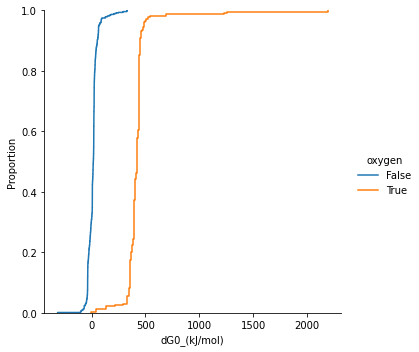

In [13]:
sns.displot(df_nicotinamide,x='dG0_(kJ/mol)',kind='ecdf',hue='oxygen')

<AxesSubplot:xlabel='coenzyme_pair', ylabel='dG0_(kJ/mol)'>

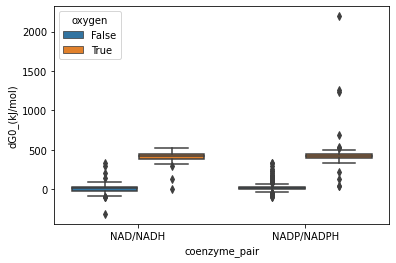

In [18]:
sns.boxplot(x = 'coenzyme_pair', y='dG0_(kJ/mol)',hue='oxygen',data=df_nicotinamide)

In [24]:
df_nicotinamide.groupby('oxygen').std()

,!dG0_prime (kJ/mol),!sigma[dG0] (kJ/mol),!pH,!I (mM),!T (Kelvin),s,multiplier,dG0_(kJ/mol)
oxygen,,,,,,,,
False,50.099357,16.850708,0.0,0.0,0.0,1.186182,0.777476,48.533000
True,176.089328,21.717118,0.0,0.0,0.0,0.419594,0.204382,155.688469


In [10]:
df_nicotinamide['coenzyme_pair'].isin(['NAD/NADH']).sum()

764

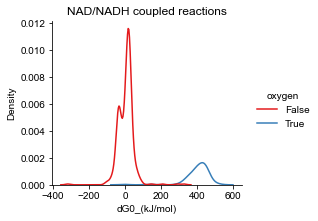

In [63]:
#dims = (4,4)
#fig, ax = plt.subplots(figsize=dims)
sns.displot(df_nad,x='dG0_(kJ/mol)',kind='kde',hue='oxygen',palette='Set1',height=3,aspect=1.2)
plt.title('NAD/NADH coupled reactions')
plt.savefig('nadCoupled.deltaGdist.oxygen.svg')

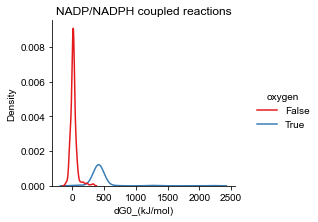

In [64]:
#dims = (4,4)
#fig, ax = plt.subplots(figsize=dims)
sns.displot(df_nadp,x='dG0_(kJ/mol)',kind='kde',hue='oxygen',palette='Set1',height=3,aspect=1.2)
plt.title('NADP/NADPH coupled reactions')
plt.savefig('nadpCoupled.deltaGdist.oxygen.svg')

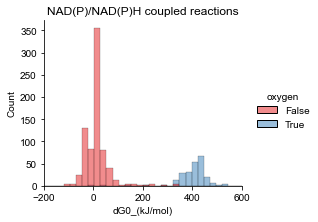

In [42]:
sns.displot(df_nicotinamide,x='dG0_(kJ/mol)',kind='hist',hue='oxygen',palette='Set1',height=3,aspect=1.2)
plt.xlim([-200,600])
plt.title('NAD(P)/NAD(P)H coupled reactions')
plt.savefig('nad_all_Coupled.deltaGdist.oxygen.svg')


In [138]:
ko = ko2rn()
ko.rn = ko.rn.apply(lambda x: x.split(':')[1])
ko.ko = ko.ko.apply(lambda x: x.split(':')[1])

In [147]:
o2_coupled = list(set(df_nadp[df_nadp['oxygen']]['!MiriamID::urn:miriam:kegg.reaction'].tolist() + df_nad[df_nad['oxygen']]['!MiriamID::urn:miriam:kegg.reaction'].tolist()))

no2_coupled = list(set(df_nadp[~df_nadp['oxygen']]['!MiriamID::urn:miriam:kegg.reaction'].tolist() + df_nad[~df_nad['oxygen']]['!MiriamID::urn:miriam:kegg.reaction'].tolist()))

In [164]:
ko_o2 = ko[ko.rn.isin(o2_coupled)].ko.unique().tolist()
ko_no2 = ko[ko.rn.isin(no2_coupled)].ko.unique().tolist()

intersect = list(set(ko_o2).intersection(set(ko_no2)))
ko_o2 = [x for x in ko_o2 if x not in intersect]
ko_no2 = [x for x in ko_no2 if x not in intersect]

In [170]:
d1 = pd.DataFrame({'NAD(P)-oxygen oxidoreductase': True, 'ko': ko_o2})
d2 = pd.DataFrame({'NAD(P)-oxygen oxidoreductase': False, 'ko': ko_no2})

In [172]:
pd.concat([d1,d2],axis=0).to_csv('../assets/kegg.ko.o2_nad_p.csv')

In [180]:
def ecogenes():
    url = 'http://rest.kegg.jp/link/ko/eco'
    r = requests.get(url)
    geneKO = pd.DataFrame([x.split('\t') for x in r.text.split('\n')],columns=['gene','ko'])
    geneKO = geneKO.iloc[0:-1]
    geneKO.ko = geneKO.ko.apply(lambda x: x.split(':')[1])
    return geneKO

In [174]:
dko = pd.concat([d1,d2],axis=0)

In [199]:
dg[dg['!MiriamID::urn:miriam:kegg.reaction'].isin(o2_coupled)]

,!MiriamID::urn:miriam:kegg.reaction,!dG0_prime (kJ/mol),!sigma[dG0] (kJ/mol),!pH,!I (mM),!T (Kelvin),!Note
92,R00111,NaN,NaN,7.0,0.1,298.15,uncertainty is too high
378,R00448,NaN,NaN,7.0,0.1,298.15,uncertainty is too high
472,R00557,-1261.0,30.0,7.0,0.1,298.15,NaN
473,R00558,NaN,NaN,7.0,0.1,298.15,uncertainty is too high
693,R00815,-443.3,15.3,7.0,0.1,298.15,NaN
696,R00818,-453.4,15.6,7.0,0.1,298.15,NaN
699,R00823,-475.2,15.6,7.0,0.1,298.15,NaN
700,R00825,-476.2,15.6,7.0,0.1,298.15,NaN
702,R00828,NaN,NaN,7.0,0.1,298.15,uncertainty is too high
834,R00980,-465.1,14.2,7.0,0.1,298.15,NaN


In [181]:
eco = ecogenes()

In [190]:
eco[eco.ko.isin(dko[dko['NAD(P)-oxygen oxidoreductase']].ko)]

,gene,ko
1378,eco:b0347,K05712
1463,eco:b2538,K05708
1464,eco:b2539,K05709
1465,eco:b2540,K05710
3058,eco:b2906,K18800


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

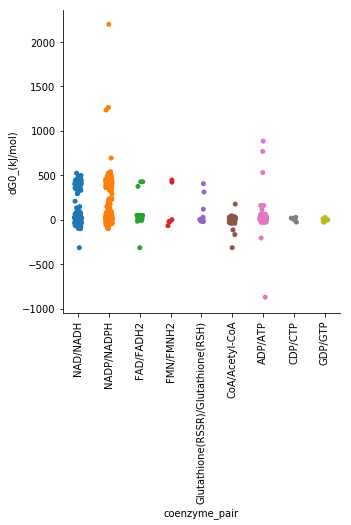

In [90]:
sns.catplot(x='coenzyme_pair',y='dG0_(kJ/mol)',data=df_all)
plt.xticks(rotation=90)

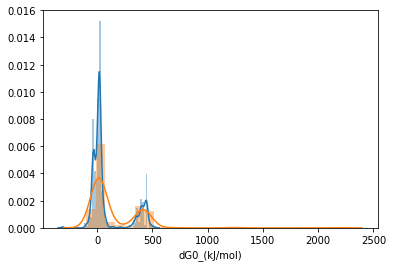

In [96]:
sns.distplot(df_all[df_all.coenzyme_pair.isin(['NAD/NADH'])]['dG0_(kJ/mol)'].dropna())
sns.distplot(df_all[df_all.coenzyme_pair.isin(['NADP/NADPH'])]['dG0_(kJ/mol)'].dropna())

In [100]:
df_all[df_all['dG0_(kJ/mol)'] > 400]

,!MiriamID::urn:miriam:kegg.reaction,!dG0_prime (kJ/mol),!sigma[dG0] (kJ/mol),!pH,!I (mM),!T (Kelvin),!Note,cid,s,multiplier,dG0_(kJ/mol),coenzyme_pair
61,R00818,-453.4,15.6,7.0,0.1,298.15,NaN,C00004,-1,-1,453.4,NAD/NADH
62,R00823,-475.2,15.6,7.0,0.1,298.15,NaN,C00004,-1,-1,475.2,NAD/NADH
101,R01296,-442.4,14.3,7.0,0.1,298.15,NaN,C00004,-1,-1,442.4,NAD/NADH
102,R01297,-453.4,15.6,7.0,0.1,298.15,NaN,C00004,-1,-1,453.4,NAD/NADH
128,R01629,-453.4,22.0,7.0,0.1,298.15,NaN,C00004,-1,-1,453.4,NAD/NADH
193,R02354,-441.7,7.8,7.0,0.1,298.15,NaN,C00004,-1,-1,441.7,NAD/NADH
195,R02383,-442.4,14.9,7.0,0.1,298.15,NaN,C00004,-1,-1,442.4,NAD/NADH
209,R02514,-442.4,14.3,7.0,0.1,298.15,NaN,C00004,-1,-1,442.4,NAD/NADH
210,R02515,-442.4,14.3,7.0,0.1,298.15,NaN,C00004,-1,-1,442.4,NAD/NADH
219,R02561,-453.5,16.1,7.0,0.1,298.15,NaN,C00004,-1,-1,453.5,NAD/NADH


In [11]:
o2_dependent = network[network.cid.isin(['C00007'])].rn.unique().tolist()

In [12]:
df_anaerobic = df_all[~df_all['!MiriamID::urn:miriam:kegg.reaction'].isin(o2_dependent)]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'NAD/NADH'),
  Text(1, 0, 'NADP/NADPH'),
  Text(2, 0, 'FAD/FADH2'),
  Text(3, 0, 'FMN/FMNH2'),
  Text(4, 0, 'Glutathione(RSSR)/Glutathione(RSH)'),
  Text(5, 0, 'CoA/Acetyl-CoA'),
  Text(6, 0, 'ADP/ATP'),
  Text(7, 0, 'CDP/CTP'),
  Text(8, 0, 'GDP/GTP')])

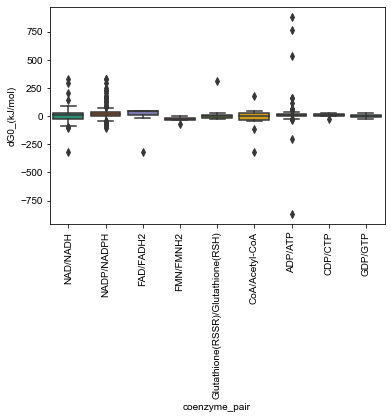

In [93]:

sns.boxplot(x='coenzyme_pair',y='dG0_(kJ/mol)',data=df_anaerobic,palette='Dark2')
plt.xticks(rotation=90)


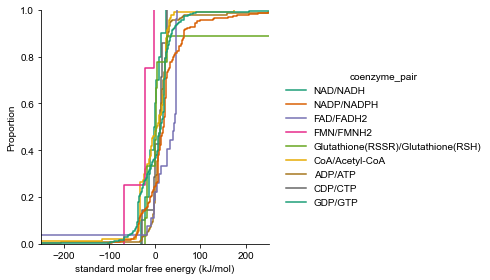

In [13]:
sns.displot(hue='coenzyme_pair',x='dG0_(kJ/mol)',data=df_anaerobic,kind="ecdf",palette='Dark2',height=4)
plt.xlabel('standard molar free energy (kJ/mol)')
plt.xlim([-250,250])
plt.savefig('keggCoenzymes.FreeEnergies.eCDF.svg')

In [17]:
coenzyme_pairs.set_index('Coenzyme Pair')

,Type,Charged,Uncharged
Coenzyme Pair,,,
NAD/NADH,Electrons: 320 mV,C00004,C00003
NADP/NADPH,Electrons: 320 mV,C00005,C00006
FAD/FADH2,Electrons: 220 mV,C01352,C00016
FMN/FMNH2,Electrons: 220 mV,C01847,C00061
Glutathione(RSSR)/Glutathione(RSH),Electrons: 220 mV,C00051,C00127
CoA/Acetyl-CoA,Acetyl Groups,C00024,C00010
ADP/ATP,Phosphate,C00002,C00008
CDP/CTP,Phosphate,C00063,C00112
GDP/GTP,Phosphate,C00044,C00035


In [21]:
dff = df_anaerobic.set_index('coenzyme_pair').join(coenzyme_pairs.set_index('Coenzyme Pair')).reset_index()

In [22]:
dff

,index,!MiriamID::urn:miriam:kegg.reaction,!dG0_prime (kJ/mol),!sigma[dG0] (kJ/mol),!pH,!I (mM),!T (Kelvin),!Note,cid,s,multiplier,dG0_(kJ/mol),Type,Charged,Uncharged
0,ADP/ATP,R00002,-766.9,47.4,7.0,0.1,298.15,NaN,C00002,-16,-1,766.9,Phosphate,C00002,C00008
1,ADP/ATP,R00076,NaN,NaN,7.0,0.1,298.15,uncertainty is too high,C00002,-4,-1,NaN,Phosphate,C00002,C00008
2,ADP/ATP,R00086,-26.4,0.6,7.0,0.1,298.15,NaN,C00002,-1,-1,26.4,Phosphate,C00002,C00008
3,ADP/ATP,R00104,-11.8,5.8,7.0,0.1,298.15,NaN,C00002,-1,-1,11.8,Phosphate,C00002,C00008
4,ADP/ATP,R00105,-10.9,5.8,7.0,0.1,298.15,NaN,C00002,-1,-1,10.9,Phosphate,C00002,C00008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1749,NADP/NADPH,R09521,NaN,NaN,7.0,0.1,298.15,uncertainty is too high,C00005,1,1,NaN,Electrons: 320 mV,C00005,C00006
1750,NADP/NADPH,R09522,NaN,NaN,7.0,0.1,298.15,uncertainty is too high,C00005,1,1,NaN,Electrons: 320 mV,C00005,C00006
1751,NADP/NADPH,R09541,207.8,16.5,7.0,0.1,298.15,NaN,C00005,1,1,207.8,Electrons: 320 mV,C00005,C00006
1752,NADP/NADPH,R09554,-40.8,33.5,7.0,0.1,298.15,NaN,C00005,1,1,-40.8,Electrons: 320 mV,C00005,C00006


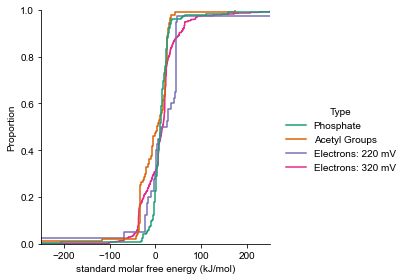

In [24]:
sns.displot(hue='Type',x='dG0_(kJ/mol)',data=dff,kind="ecdf",palette='Dark2',height=4)
plt.xlabel('standard molar free energy (kJ/mol)')
plt.xlim([-250,250])
plt.savefig('keggCoenzymes.FreeEnergies.GroupTransfers.eCDF.svg')

In [26]:
dff['r'] = 1

In [28]:
dff.groupby('Type').sum()

,!dG0_prime (kJ/mol),!sigma[dG0] (kJ/mol),!pH,!I (mM),!T (Kelvin),s,multiplier,dG0_(kJ/mol),r
Type,,,,,,,,,
Acetyl Groups,-769.9,1482.6,994.0,14.2,42337.30,-89,-88,-261.9,142
Electrons: 220 mV,194.2,824.5,441.0,6.3,18783.45,2,15,628.2,63
Electrons: 320 mV,110.8,11754.3,8309.0,118.7,353904.05,678,747,9403.6,1187
Phosphate,-4130.1,3742.6,2534.0,36.2,107930.30,-380,-338,4235.9,362
